# **신용카드 승인이 여부 예측하기**
---
**문제 정의**  

* 최근 카드 가맹점의 수수료 인하 등으로 인해 수익이 줄어든 카드사들이 리볼빙 서비스를 확대하고 있다.  
 이로 인해 대출이 늘어나니 연체 또한 같이 증가하는 현상이 발생 되는 실정이다.  
 연체 발생 시 고객 관리가 어렵고 회사의 수익성에도 영향을 끼치며, 장기 지속될 경우 신용불량자가 증가하는 사회문제로 이어지게 된다. 이에 고객 정보를 미리 파악하여 연체 가능 여부를 체크하고, 카드 발급 시 심사 오류로 인해 발급 불가능한 고객에 발급이 되지 않도록 예방하자.
---
**분류 문제**   
* 연체 여부 확인을 통해 발급가능 / 불가능을 확인하는 분류 문제로 정의된다.
---
**가설 설정**   
* 나이는 신용카드 연체 여부에 연관성이 있다.  
  : 실제로 연체가 가장 잦은 나이는 25세라는 조사 결과가 있어서 확인하고자 한다.  
---
**처리 순서**  

1. 데이터셋 불러오기
2. EDA 및 Feature engineering
 1) 결측치 확인 및 제거  
 2) 중복값 확인 및 제거  
 3) Feature Engineering   
 4) 이상치 확인 및 제거  
 5) Target 값 선정  
 6) Data 분포 확인
6. 가설 검증
7. 모델링  
 1) 기준모델  
 2) 가중치를 준 뒤 모델링  
 3) 오버샘플링 후 모델링    
 4) 최종모델 선택  
 5) 특성중요도
8. 최종 결론  
 1) 가설 해결  
 2) 최종 모델 
---

In [ ]:
pip install category_encoders
pip install pdpbox
pip install shap
pip install eli5

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from category_encoders import OrdinalEncoder
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
from scipy.stats import randint
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

application = pd.read_csv('/content/drive/MyDrive/Python/application_record.csv')
credit = pd.read_csv('/content/drive/MyDrive/Python/credit_record.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
### 데이터 파악하기
---
## application set columns

ID : 고객번호  

CODE_GENDER	: 성별  

FLAG_OWN_CAR : 차 소유 여부

FLAG_OWN_REALTY	: 집 소유 여부

CNT_CHILDREN : 자녀의 수	

AMT_INCOME_TOTAL : 연간 소득

NAME_INCOME_TYPE : 소득 카테고리	

NAME_EDUCATION_TYPE	: 교육 수준	

NAME_FAMILY_STATUS :	결혼 여부	

NAME_HOUSING_TYPE : 살아가는 방법

DAYS_BIRTH : 생일	현재 날짜(0)에서 거꾸로 계산.  -1은 어제를 의미

DAYS_EMPLOYED : 고용 시작일	현재 날짜(0)부터 거꾸로 계산.  양성이면 현재 실직 중

FLAG_MOBIL : 휴대 전화 보유 여부

FLAG_WORK_PHONE : 직장 전화 보유 여부

FLAG_PHONE : 전화 보유 여부

FLAG_EMAIL : 이메일이 보유 여부

OCCUPATION_TYPE : 직업	

CNT_FAM_MEMBERS	: 가족 수

---

## credit set columns

ID : 고객 번호  

MONTHS_BALANCE : 기록월 ( 추출된 데이터의 월은 시작점. 역순으로 0은 현재 월, -1은 이전 월)  

STATUS : 현재 상태  
(0: 1-29일 연체  
 1: 30-59일 연체  
 2: 60-89일 연체  
 3: 90-119일 연체  
 4: 연체 120-149일  
 5: 연체 또는 불량 부채, 상각 150일  
 C: 해당 월 상환  
 X: 해당 월 대출 없음)

 ---

In [3]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [5]:
application.nunique()

# MOBIL 은 전체가 같은 값을 가지기 때문에 데이터에 큰 영향을 주지 않을 듯 하다. 삭제해야겠음

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [6]:
credit.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [7]:
application.shape, credit.shape

((438557, 18), (1048575, 3))

---
# EDA 및 Preprocessing
## 결측치 확인 및 제거

In [8]:
application.isnull().sum()  # 결측치가 직업 부분에만 존재함

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [9]:
# 결측치 -> Unknown
application['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

# 결측치가 Unknown 으로 잘 처리된 것 확인
application['OCCUPATION_TYPE'].value_counts()

Unknown                  134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

In [10]:
credit.isnull().sum()    # 결측치 없음

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

---
## 중복값 확인 및 제거

In [11]:
application.duplicated().sum(), credit.duplicated().sum()   # 중복 데이터 없음

(0, 0)

---
## Feature Engineering
[application]
* AMT_INCOME_TOTAL, CNT_FAM_MEMBERS  : float -> int  
* DAYS_BIRTH, DAYS_EMPLOYED : DAY 기준에서 YEAR로 변경. (-)계산 값을 (+)로 변경  
* 다른 컬럼은 Y=1, N=0로 표현 되어 있는데, FLAG_OWN_CAR,	FLAG_OWN_REALITY는 Y / N 인 상태라 1 / 0으로 통일  
* FLAG_MOBIL 컬럼 삭제
* NAME_INCOME_TYPE 의 ['Working', 'Commercial associate', 'Pensioner', 'State servant','Student'] value 중 'Commercial associate', 'State servant'는 Working와 동일하므로 변경

In [12]:
#float -> int 
application[['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']] = application[['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']].astype(int)

# DAYS_EMPLOYED 값 중 0보다 큰 값(퇴직자)는 모두 0으로 변경
application['DAYS_EMPLOYED'] = application['DAYS_EMPLOYED'].apply(lambda x : 0 if (x > 0) else x)

# (-) -> (+)로, DAY 기준을 YEAR로 변경
application[['DAYS_BIRTH', 'DAYS_EMPLOYED']] = ((application[['DAYS_BIRTH', 'DAYS_EMPLOYED']] * -1) / 365).astype(int)

# Y / N -> 1 / 0으로 통일 
application['FLAG_OWN_CAR'] = application['FLAG_OWN_CAR'].apply(lambda x : 1 if (x == 'Y') else 0)
application['FLAG_OWN_REALTY'] = application['FLAG_OWN_REALTY'].apply(lambda x : 1 if (x == 'Y') else 0)

# F / M -> 1 / 0으로 통일 
application['CODE_GENDER'] = application['CODE_GENDER'].apply(lambda x : 1 if (x == 'F') else 0)

# FLAG_MOBIL 컬럼 삭제
application.drop(columns=['FLAG_MOBIL'], inplace=True)

# Commercial associate', 'State servant' -> Working
application['NAME_INCOME_TYPE'] = application['NAME_INCOME_TYPE'].\
                                replace('Commercial associate', 'Working').replace('State servant', 'Working')


[credit set columns]
* MONTHS_BALANCE : (-)계산 값을 (+)로 변경

In [13]:
credit['MONTHS_BALANCE'] = credit['MONTHS_BALANCE'] * -1

#### column 명 변경

In [14]:
application.columns = ['ID', 'GENDER', 'OWN_CAR', 'OWN_REALITY', 'CHILDREN_COUNT', 'TOTAL_INCOME',
                       'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_TYPE', 'AGE',
                       'WORKING_YEAR', 'WORK_PHONE', 'PHONE', 'EMAIL', 'OCCUPATION', 'FAM_MEMBERS']

---
## 이상치 확인 및 제거

[Text(0.5, 0, 'AGE')]

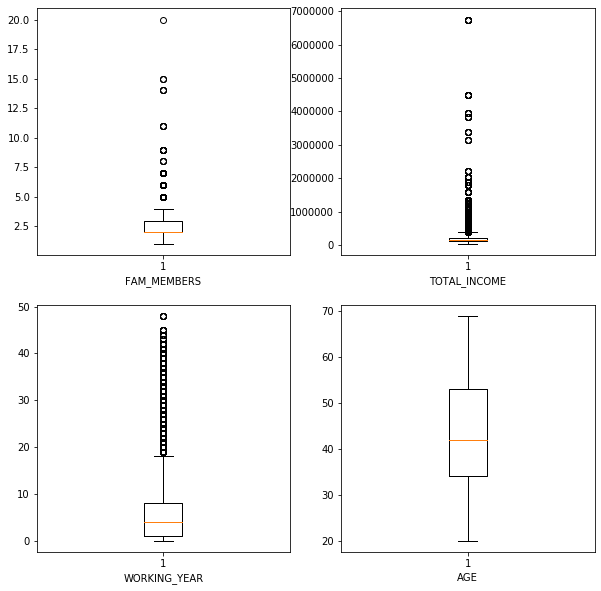

In [15]:
fig, axs = plt.subplots(2,2, figsize=(10,10))      

axs[0,0].boxplot(application['FAM_MEMBERS'])
axs[0,0].set(xlabel='FAM_MEMBERS')
axs[0,1].boxplot(application['TOTAL_INCOME'])
axs[0,1].set(xlabel='TOTAL_INCOME')
axs[1,0].boxplot(application['WORKING_YEAR'])
axs[1,0].set(xlabel='WORKING_YEAR')
axs[1,1].boxplot(application['AGE']);
axs[1,1].set(xlabel='AGE')

In [16]:
# 3개 컬럼에 대해 99% 값만 사용
application = application[
    (application['FAM_MEMBERS'] <= np.percentile(application['FAM_MEMBERS'], 95))]
application = application[
    (application['TOTAL_INCOME'] <= np.percentile(application['TOTAL_INCOME'], 95))]
application = application[
    (application['WORKING_YEAR'] <= np.percentile(application['WORKING_YEAR'], 95))]

---
## Target 값 선정
 * 연체가 있으면 1로 승인 불가, 연체가 없으면 0으로 승인 가능하게 처리  
 (X, C = 0, 나머지는 1)

In [17]:
# 연체가 없는 'C', 'X'는 'N'로  연체가 있는 나머지 값은 'Y'로 변경
credit['STATUS'] = credit['STATUS'].apply(lambda x: 'N' if x == 'X' else ('N' if x == 'C' else 'Y'))

# OVERDUE 컬럼 만들어서 연체가 있으면 1로 변경. 없으면 None
credit['OVERDUE'] = None
credit['OVERDUE'][credit['STATUS'] == 'Y'] = 1

# ID로 그룹화 한 뒤 count ==> 연체가 있으면 값이 > 0, 없으면 = 0
# 결국 현재 하나라도 연체가 있는 ID는 1로, 연체가 없는 ID는 0으로 표현
credit = credit.groupby('ID').count()
credit['OVERDUE'][credit['OVERDUE'] > 0] = 1

In [18]:
credit.drop(columns=['STATUS'], inplace=True)
credit.columns = ['USE_MONTH', 'OVERDUE']
credit['OVERDUE'].value_counts()

1    40032
0     5953
Name: OVERDUE, dtype: int64

---
### clean data에 대해 각 cloumn 별 분포 확인

In [19]:
# 데이터 MERGE
df = pd.merge(application, credit, on='ID', how='inner')
#df.shape (36457*19)

1) Target = OVERDUE 의 분포
- 불균형한 데이터이기 때문에 모델링 할 때 유의해야함.

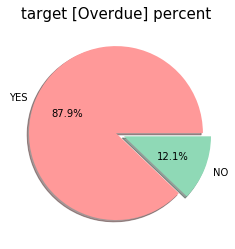

In [20]:
# Target value 시각화
ratio = df['OVERDUE'].value_counts(normalize=True)*100

ratio_ = [ratio[1], ratio[0]]
labels = ['YES', 'NO']
explode = [0, 0.1]
plt.pie(ratio_, labels=labels, autopct='%.1f%%', explode=explode,
       shadow=True, colors=['#ff9999', '#8fd9b6'])
plt.title('target [Overdue] percent', fontsize=15);

2) GENDER / OWN_CAR / OWN_REALITY

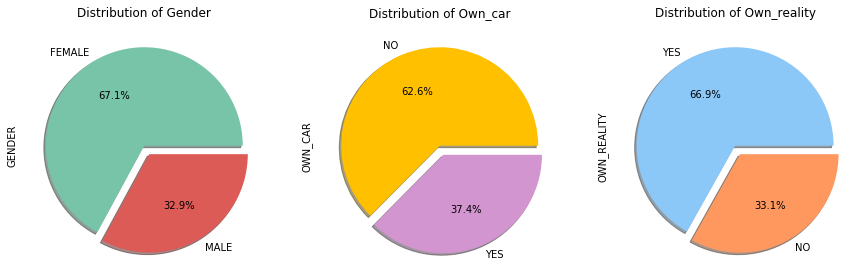

In [21]:
fig, axes = plt.subplots(1,3, figsize=(15,10))


pie1 = df['GENDER'].value_counts().plot.pie(explode=explode, autopct='%.1f%%', ax=axes[0],
                                            shadow=True, colors=['#77C4A8', '#DC5B57'], labels = ['FEMALE', 'MALE'])
pie1.set_title('Distribution of Gender', fontsize=12)

pie2 = df['OWN_CAR'].value_counts().plot.pie(explode=explode, autopct='%.1f%%', ax=axes[1],
                                            shadow=True, colors=['#ffc000', '#d395d0'], labels = ['NO', 'YES'])
pie2.set_title('Distribution of Own_car', fontsize=12)

pie3 = df['OWN_REALITY'].value_counts().plot.pie(explode=explode, autopct='%.1f%%', ax=axes[2],
                                            shadow=True, colors=['#8BC7F7', '#FF985E'], labels = ['YES', 'NO'])
pie3.set_title('Distribution of Own_reality', fontsize=12);

3) TOTAL_INCOME / AGE /	WORKING_YEAR / FAM_MEMBERS

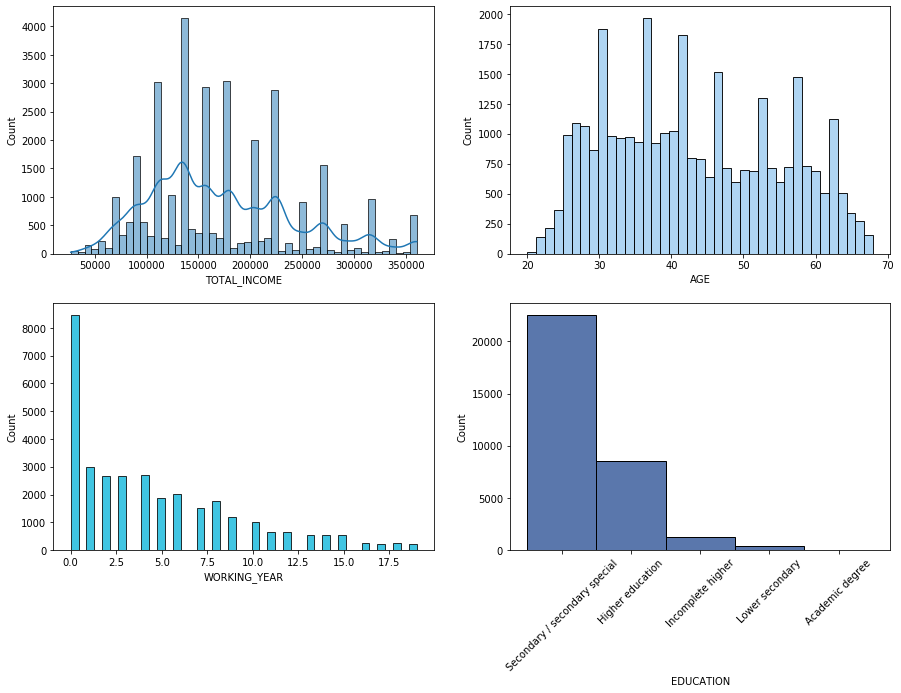

In [22]:
fig, axes = plt.subplots(2,2, figsize=(15,10))

hist1 = sns.histplot(data=df, x='TOTAL_INCOME', ax=axes[0,0], kde=True);
hist2 = sns.histplot(data=df, x='AGE', ax=axes[0,1], color='#95C8F0');
hist3 = sns.histplot(data=df, x='WORKING_YEAR', ax=axes[1,0], color='#00B2D9');
hist4 = sns.histplot(data=df, x='EDUCATION', ax=axes[1,1], color='#234990');
plt.xticks(rotation=45);

WORKING_YEAR 을 보면 근무 연수가 짧은 사람이 긴 사람보다 상대적으로 많이 분포되어있다.  
그럼에도 불구하고 TOTAL_INCOME은 나름대로(?) 골고루 분포되어있는 듯 하다.  

그럼 TOTAL_INCOME과 WORK_YEAR, EDUCATION 간의 관계는 어떻게 될까?

---

#### INCOME 과 EDUCATION 관계

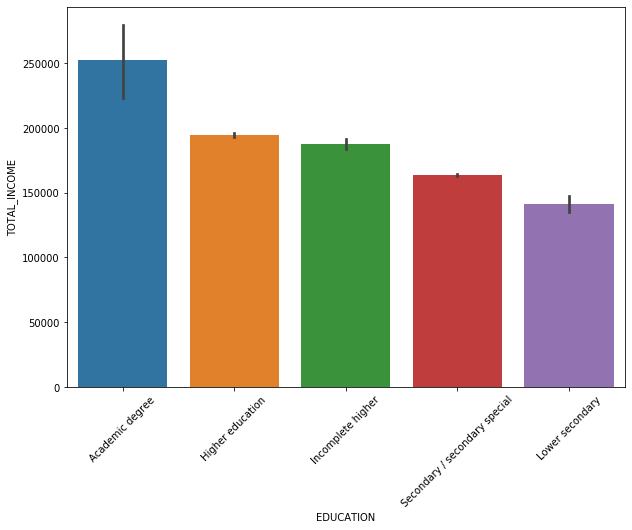

In [23]:
rcParams['figure.figsize'] = 10,7
bar1 = sns.barplot(x='EDUCATION', y='TOTAL_INCOME', data=df,
                   order = ['Academic degree', 'Higher education', 'Incomplete higher',
                            'Secondary / secondary special', 'Lower secondary'])
plt.xticks(rotation=45);

# 교육수준은 Academic degree > Higher education > Incomplete higher > Secondaty/secondary special > Lower secondary 순
# 학력이 높을 수록 income이 높게 나타나는 것을 볼 수 있다.

#### INCOME 과 WORKING YEAR 관계

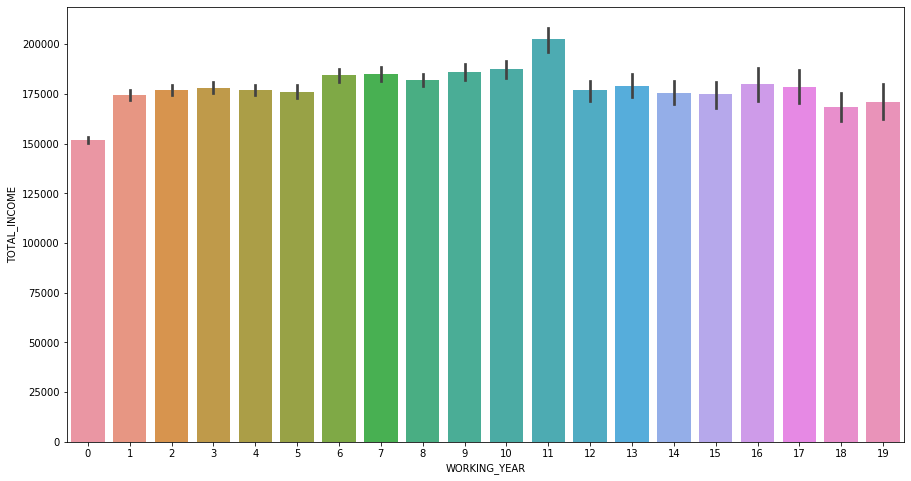

In [24]:
rcParams['figure.figsize'] = 15, 8
sns.barplot(x='WORKING_YEAR', y='TOTAL_INCOME', data=df)

# 연차가 높아지면 income이 많을 거라고 생각했는데, 아주 초기가 아니면 비슷한 수준이다.

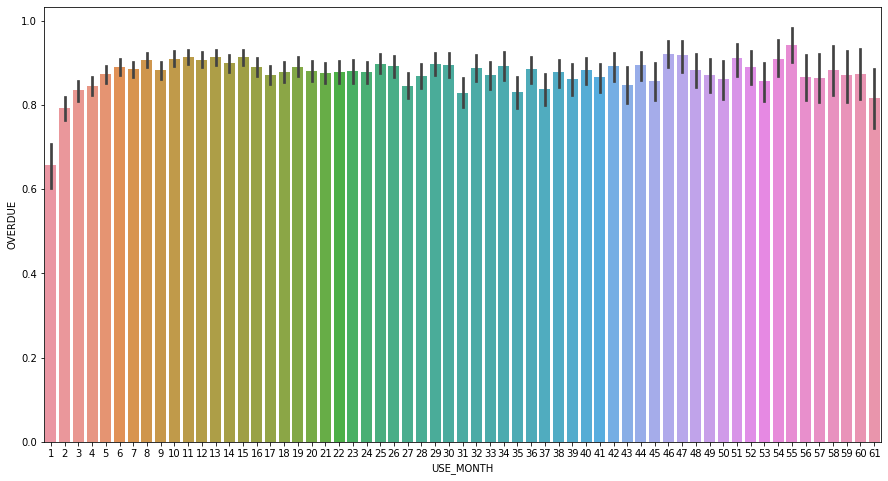

In [62]:
sns.barplot(x='USE_MONTH', y='OVERDUE', data=df)

---
#### Feature 간 상관관계

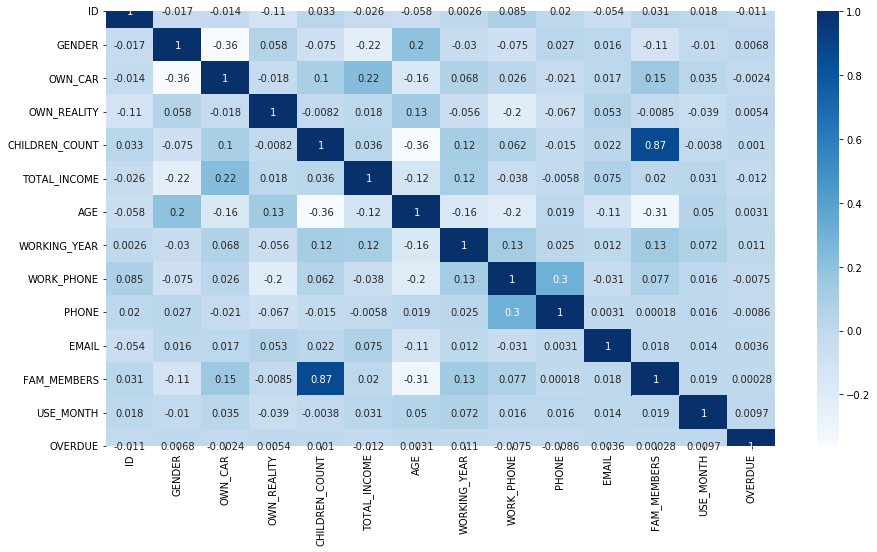

In [25]:
corr = df.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

CHILDREN_COUNT 와 FAM_MEMBERS 가 높은 상관관계를 가지는 것을 발견.  
CHILDREN_COUNT 컬럼을 추가 삭제 해줘야겠다.

ID는 이름이나 마찬가지이니 삭제해야겠음.

In [26]:
df = df.drop(['CHILDREN_COUNT', 'ID', 'USE_MONTH'], axis=1)

---
# 가설검정
### H1 : 나이는 연체 여부에 연관성이 있다.   
### H0 : 나이는 연체 여부에 연관성이 없다.
- 신뢰구간 : 95%

In [27]:
data = pd.crosstab(df['AGE'], df['OVERDUE'])
p_value = chi2_contingency(data, correction=False)[1]

print('p_value :', p_value)

p_value : 1.0362160143634882e-20


p_value < 0.5 => H0 기각, H1 채택. 결국 나이은 연체 여부랑 관계가 있다.  
생각했던 대로 관계가 있는 것으로 나왔다.

--- 
# 모델링
### Data Split


In [28]:
target = 'OVERDUE'
features = df.drop(columns=target).columns

train, test = train_test_split(df, train_size=0.8, random_state=42, shuffle=True, stratify=df[target])
train, val = train_test_split(train, train_size=0.8, random_state=42, shuffle=True, stratify=train[target])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

train.shape, val.shape, test.shape

((20963, 17), (5241, 17), (6552, 17))

### 기준모델

In [29]:
pipe_base = make_pipeline(OrdinalEncoder(), RandomForestClassifier(random_state=42))
pipe_base.fit(X_train, y_train)

pred_train = pipe_base.predict(X_train)
pred_val = pipe_base.predict(X_val)

print('training f1_score :', f1_score(y_train, pred_train))
print('validation f1_score :', f1_score(y_val, pred_val))

training f1_score : 0.9911107508578532
validation f1_score : 0.9373481246698361


---
## 가중치를 준 뒤 모델링

 불균형 데이터이므로 가중치를 줘서 모델링  


**데이터 셋의 FP & FN**

FP : 연체가 없는데 있다고 판단하고, 카드 발급 승인을 거부하는 경우  
FN : 연체가 있는데 없다고 판단하고, 카드 발급 승인을 해주는 경우  -> critical  
 
평가 지표 중 recall에 대한 성능이 뛰어난 것이 좋음.

### * Decision Tree

In [30]:
pipe = make_pipeline(OrdinalEncoder(),
                    DecisionTreeClassifier(random_state=42, class_weight='balanced'))

dist = {'decisiontreeclassifier__criterion' : ['gini', 'entropy', 'log_loss'],
       'decisiontreeclassifier__max_depth' : randint(3, 20),
       'decisiontreeclassifier__min_samples_split' : randint(10, 30),
       'decisiontreeclassifier__min_samples_leaf' : randint(10, 50),
       'decisiontreeclassifier__max_features' : ['sqrt', 'log2', None]}

clf1 = RandomizedSearchCV(pipe,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,  
                        n_jobs = -1)

clf1.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('decisiontreeclassifier',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'decisiontreeclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'decisiontreeclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f982264fc90>,
                                        'decisiontreeclassifier__max_features': ['sqrt',
                                                        

In [31]:
pd.DataFrame(clf1.cv_results_).sort_values(by='rank_test_score').T

,8,1,4,7,3,0,2,5,6,9
mean_fit_time,0.140519,0.192859,0.18987,0.126688,0.123875,0.126173,0.118942,0.11069,0.11175,0.11202
std_fit_time,0.009439,0.010292,0.004852,0.005021,0.006648,0.008364,0.002264,0.000847,0.00258,0.005353
mean_score_time,0.042349,0.037416,0.036037,0.035542,0.035999,0.0,0.0,0.0,0.0,0.0
std_score_time,0.010067,0.002989,0.00272,0.000639,0.002805,0.0,0.0,0.0,0.0,0.0
param_decisiontreeclassifier__criterion,entropy,entropy,gini,entropy,gini,log_loss,log_loss,log_loss,log_loss,log_loss
param_decisiontreeclassifier__max_depth,11,13,19,6,3,17,4,17,9,9
param_decisiontreeclassifier__max_features,log2,None,None,sqrt,log2,None,log2,log2,sqrt,sqrt
param_decisiontreeclassifier__min_samples_leaf,11,33,37,23,31,17,47,12,18,17
param_decisiontreeclassifier__min_samples_split,29,13,25,27,21,16,11,14,16,24
params,{'decisiontreeclassifier__criterion': 'entropy...,{'decisiontreeclassifier__criterion': 'entropy...,"{'decisiontreeclassifier__criterion': 'gini', ...",{'decisiontreeclassifier__criterion': 'entropy...,"{'decisiontreeclassifier__criterion': 'gini', ...",{'decisiontreeclassifier__criterion': 'log_los...,{'decisiontreeclassifier__criterion': 'log_los...,{'decisiontreeclassifier__criterion': 'log_los...,{'decisiontreeclassifier__criterion': 'log_los...,{'decisiontreeclassifier__criterion': 'log_los...


In [32]:
best_model_dt1 = clf1.best_estimator_

y_pred_train = best_model_dt1.predict(X_train)
y_pred_val = best_model_dt1.predict(X_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.6408910938319897
검증 정확도:  0.609234878839916
              precision    recall  f1-score   support

           0       0.16      0.54      0.25       636
           1       0.91      0.62      0.74      4605

    accuracy                           0.61      5241
   macro avg       0.54      0.58      0.49      5241
weighted avg       0.82      0.61      0.68      5241



---
### * RandomForest

In [33]:
pipe = make_pipeline(OrdinalEncoder(),
                    RandomForestClassifier(random_state=42, class_weight='balanced'))

dist = {'randomforestclassifier__criterion' : ['gini', 'entropy', 'log_loss'],
        'randomforestclassifier__n_estimators' : randint(10, 1000),
       'randomforestclassifier__max_depth' : randint(3, 100),
       'randomforestclassifier__min_samples_split' : randint(10, 100),
       'randomforestclassifier__min_samples_leaf' : randint(10, 100),
       'randomforestclassifier__max_features' : ['sqrt', 'log2', None]}

clf2 = RandomizedSearchCV(pipe,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf2.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_...
                                        'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9820db9710>,
                   

In [34]:
pd.DataFrame(clf2.cv_results_).sort_values(by='rank_test_score').T

,8,2,4,9,3,1,0,5,6,7
mean_fit_time,27.968621,35.256974,9.192656,5.538836,4.228935,3.648541,0.561063,0.731504,0.459332,0.510561
std_fit_time,0.342451,0.304458,0.365455,0.749941,0.026915,0.029066,0.010341,0.016998,0.007212,0.011399
mean_score_time,0.854819,1.410139,0.85649,0.469353,0.389706,0.180437,0.0,0.0,0.0,0.0
std_score_time,0.089376,0.341712,0.048659,0.033111,0.009608,0.025762,0.0,0.0,0.0,0.0
param_randomforestclassifier__criterion,gini,gini,gini,entropy,entropy,gini,log_loss,log_loss,log_loss,log_loss
param_randomforestclassifier__max_depth,75,26,78,11,40,85,54,61,64,66
param_randomforestclassifier__max_features,None,None,log2,log2,log2,None,sqrt,None,log2,sqrt
param_randomforestclassifier__min_samples_leaf,27,31,31,62,73,84,24,51,56,12
param_randomforestclassifier__min_samples_split,13,62,98,11,69,84,81,69,71,60
param_randomforestclassifier__n_estimators,610,779,570,349,286,97,710,985,572,656


In [35]:
best_model_rf1 = clf2.best_estimator_

y_pred_train = best_model_rf1.predict(X_train)
y_pred_val = best_model_rf1.predict(X_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.8778323713208988
검증 정확도:  0.8143484067925968
              precision    recall  f1-score   support

           0       0.30      0.40      0.34       636
           1       0.91      0.87      0.89      4605

    accuracy                           0.81      5241
   macro avg       0.61      0.63      0.62      5241
weighted avg       0.84      0.81      0.83      5241



---
### * XGBoost

In [36]:
pipe = make_pipeline(OrdinalEncoder(),
                    XGBClassifier(random_state=42))

dist = {
    'xgbclassifier__learning_rate' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    'xgbclassifier__n_estimators' : randint(10, 1000),
    'xgbclassifier__max_depth' : randint(5, 100),
    'xgbclassifier__scale_pos_weight' : [1, 2, 3, 4, 5]
}
    

clf3 = RandomizedSearchCV(pipe,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,  
                        n_jobs = -1)

clf3.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('xgbclassifier',
                                              XGBClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'xgbclassifier__learning_rate': [0.1,
                                                                         0.15,
                                                                         0.2,
                                                                         0.25,
                                                                         0.3,
                                                                         0.35],
                                        'xgbclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9825703590>,
                                        'xgbclassifier__n_es

In [37]:
pd.DataFrame(clf3.cv_results_).sort_values(by='rank_test_score').T

,3,6,7,5,2,8,0,4,9,1
mean_fit_time,16.177539,30.060078,59.239675,18.754503,38.047751,76.06539,30.827916,55.371451,24.529005,55.702305
std_fit_time,0.186347,0.632679,1.475425,0.096403,0.47285,1.352822,0.451594,1.052618,2.987323,0.541819
mean_score_time,0.344334,0.77519,1.995388,0.402762,1.02172,2.761367,0.784762,1.704086,0.562115,1.680575
std_score_time,0.007278,0.012661,0.083479,0.005942,0.02796,0.135736,0.024752,0.036264,0.061069,0.028884
param_xgbclassifier__learning_rate,0.3,0.15,0.1,0.25,0.2,0.15,0.25,0.15,0.25,0.3
param_xgbclassifier__max_depth,28,26,53,25,91,96,97,92,59,25
param_xgbclassifier__n_estimators,140,262,484,170,340,709,280,501,253,624
param_xgbclassifier__scale_pos_weight,5,4,3,4,3,3,3,2,1,2
params,"{'xgbclassifier__learning_rate': 0.3, 'xgbclas...","{'xgbclassifier__learning_rate': 0.15, 'xgbcla...","{'xgbclassifier__learning_rate': 0.1, 'xgbclas...","{'xgbclassifier__learning_rate': 0.25, 'xgbcla...","{'xgbclassifier__learning_rate': 0.2, 'xgbclas...","{'xgbclassifier__learning_rate': 0.15, 'xgbcla...","{'xgbclassifier__learning_rate': 0.25, 'xgbcla...","{'xgbclassifier__learning_rate': 0.15, 'xgbcla...","{'xgbclassifier__learning_rate': 0.25, 'xgbcla...","{'xgbclassifier__learning_rate': 0.3, 'xgbclas..."
split0_test_score,0.9359,0.935277,0.934578,0.935486,0.934044,0.933449,0.934191,0.933554,0.93147,0.931716


In [38]:
best_model_xgb1 = clf3.best_estimator_

y_pred_train = best_model_xgb1.predict(X_train)
y_pred_val = best_model_xgb1.predict(X_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.9823021514096265
검증 정확도:  0.8858996374737645
              precision    recall  f1-score   support

           0       0.56      0.27      0.36       636
           1       0.91      0.97      0.94      4605

    accuracy                           0.89      5241
   macro avg       0.73      0.62      0.65      5241
weighted avg       0.86      0.89      0.87      5241



---
### * LightGBM

In [39]:
pipe = make_pipeline(OrdinalEncoder(),
                    LGBMClassifier(random_state=42, boost_from_average=False))

dist = {
    'lgbmclassifier__learning_rate' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    'lgbmclassifier__n_estimators' : randint(10, 1000),
    'lgbmclassifier__num_iterations' : randint(50, 500),
    'lgbmclassifier__min_data_in_leaf ' : randint(10, 100),
    'lgbmclassifier__max_depth' : randint(5, 50),
    'lgbmclassifier__scale_pos_weight' : [1, 2, 3, 4, 5]
}
    

clf4 = RandomizedSearchCV(pipe,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf4.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('lgbmclassifier',
                                              LGBMClassifier(boost_from_average=False,
                                                             random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.1,
                                                                          0.15,
                                                                          0.2,
                                                                          0.25,
                                                                          0.3,
                                                                          0.35],
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.r

In [40]:
pd.DataFrame(clf4.cv_results_).sort_values(by='rank_test_score').T

,9,3,2,1,6,0,5,4,8,7
mean_fit_time,1.376756,1.569174,0.766281,1.33821,1.770723,0.552665,0.500291,0.371237,0.373254,0.385422
std_fit_time,0.277019,0.004265,0.01564,0.018889,0.013365,0.001868,0.018195,0.00859,0.00616,0.006014
mean_score_time,0.256958,0.277981,0.131009,0.194661,0.269839,0.090819,0.077253,0.061928,0.070871,0.069342
std_score_time,0.059678,0.038199,0.005746,0.003579,0.008724,0.003707,0.001362,0.000836,0.001795,0.00133
param_lgbmclassifier__learning_rate,0.15,0.15,0.3,0.3,0.25,0.25,0.25,0.3,0.15,0.25
param_lgbmclassifier__max_depth,13,28,40,43,20,33,29,37,8,7
param_lgbmclassifier__min_data_in_leaf,99,39,33,92,24,24,58,85,98,60
param_lgbmclassifier__n_estimators,574,815,140,224,199,116,484,323,325,656
param_lgbmclassifier__num_iterations,435,435,199,380,495,121,108,71,63,70
param_lgbmclassifier__scale_pos_weight,4,4,5,3,3,5,2,5,2,1


In [41]:
best_model_lgbm1 = clf4.best_estimator_

y_pred_train = best_model_lgbm1.predict(X_train)
y_pred_val = best_model_lgbm1.predict(X_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.9151838954348137
검증 정확도:  0.8849456210646823
              precision    recall  f1-score   support

           0       0.63      0.12      0.21       636
           1       0.89      0.99      0.94      4605

    accuracy                           0.88      5241
   macro avg       0.76      0.56      0.57      5241
weighted avg       0.86      0.88      0.85      5241



XGboost는 과적합이 심하게 나와서 적합한 모델이라고 할 수 없다.  
LightGBM도 꽤나 높은 score가 나오는데 데이터 누수가 일어난건 아닌가.. 하는 생각이 들었다.  
데이터를 한참 살펴봤지만 잘 모르겠다..  

---
## 오버샘플링 후 모델링

#### Data_split

In [42]:
# ADASYN 는 숫자형만 받아들이기 때문에 카테고리 형을 인코딩해준다.
df1 = df.copy()
enc = OrdinalEncoder()
enc.fit(df1)
df1 = enc.transform(df1)

In [43]:
target = 'OVERDUE'
features = df1.drop(columns=target).columns

train, test = train_test_split(df1, train_size=0.8, random_state=42,  shuffle=True,  stratify=df[target])
train, val = train_test_split(train, train_size=0.8, random_state=42,  shuffle=True, stratify=train[target])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

#### ADASYN을 통해 over-sampling

In [44]:
# ADASYN을 통해 over-sampling
sampling = ADASYN()

X_train_sm, y_train_sm = sampling.fit_resample(X_train, y_train)
X_val_sm, y_val_sm = sampling.fit_resample(X_val, y_val)
X_test_sm, y_test_sm = sampling.fit_resample(X_test, y_test)

In [45]:
y_train_sm.value_counts(), y_val_sm.value_counts()

(0    18537
 1    18417
 Name: OVERDUE, dtype: int64, 1    4605
 0    4440
 Name: OVERDUE, dtype: int64)

### * Decision Tree

In [46]:
pipe = make_pipeline(DecisionTreeClassifier(random_state=42))

dist = {'decisiontreeclassifier__criterion' : ['gini', 'entropy', 'log_loss'],
       'decisiontreeclassifier__max_depth' : randint(3, 50),
       'decisiontreeclassifier__min_samples_split' : randint(10, 50),
       'decisiontreeclassifier__min_samples_leaf' : randint(10, 100),
       'decisiontreeclassifier__max_features' : ['sqrt', 'log2', None]}

clf1 = RandomizedSearchCV(pipe,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf1.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('decisiontreeclassifier',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'decisiontreeclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'decisiontreeclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9825f3cad0>,
                                        'decisiontreeclassifier__max_features': ['sqrt',
                                                                                 'log2',
                                                                                 None],
                                        'decisiontreeclassifier__min_samples_leaf': <scipy.stats._dist

In [47]:
best_model_dt_fin = clf1.best_estimator_

y_pred_train = best_model_dt_fin.predict(X_train_sm)
y_pred_val = best_model_dt_fin.predict(X_val_sm)

print('훈련 정확도: ', accuracy_score(y_train_sm, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val_sm, y_pred_val))
print(classification_report(y_val_sm, y_pred_val))

훈련 정확도:  0.8031606862585917
검증 정확도:  0.7320066334991708
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      4440
           1       0.72      0.77      0.74      4605

    accuracy                           0.73      9045
   macro avg       0.73      0.73      0.73      9045
weighted avg       0.73      0.73      0.73      9045



### * RandomForest

In [48]:
pipe_rf = make_pipeline(RandomForestClassifier(random_state=42))

dist = {'randomforestclassifier__criterion' : ['gini', 'entropy', 'log_loss'],
        'randomforestclassifier__n_estimators' : randint(10, 500),
       'randomforestclassifier__max_depth' : randint(3, 100),
       'randomforestclassifier__min_samples_split' : randint(10, 100),
       'randomforestclassifier__min_samples_leaf' : randint(10, 100),
       'randomforestclassifier__max_features' : ['sqrt', 'log2', None]}

clf2 = RandomizedSearchCV(pipe_rf,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf2.fit(X_train_sm, y_train_sm)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9822626890>,
                                        'randomforestclassifier__max_f...
                                        'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f982559a190>,
                                        'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object a

In [49]:
best_model_rf_fin = clf2.best_estimator_

y_pred_train = best_model_rf_fin.predict(X_train_sm)
y_pred_val = best_model_rf_fin.predict(X_val_sm)

print('훈련 정확도: ', accuracy_score(y_train_sm, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val_sm, y_pred_val))
print(classification_report(y_val_sm, y_pred_val))

훈련 정확도:  0.8333333333333334
검증 정확도:  0.7645107794361525
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      4440
           1       0.74      0.82      0.78      4605

    accuracy                           0.76      9045
   macro avg       0.77      0.76      0.76      9045
weighted avg       0.77      0.76      0.76      9045



### * XGBoost

In [50]:
pipe = make_pipeline(XGBClassifier(random_state=42))

dist = {
    'xgbclassifier__learning_rate' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    'xgbclassifier__n_estimators' : randint(10, 1000),
    'xgbclassifier__max_depth' : randint(5, 100),
    'xgbclassifier__scale_pos_weight' : [1, 2, 3, 4, 5]
}
    

clf3 = RandomizedSearchCV(pipe,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf3.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('xgbclassifier',
                                              XGBClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'xgbclassifier__learning_rate': [0.1,
                                                                         0.15,
                                                                         0.2,
                                                                         0.25,
                                                                         0.3,
                                                                         0.35],
                                        'xgbclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9831dd1d90>,
                                        'xgbclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9831dd1a50>,
                                        'xgbcl

In [51]:
best_model_xgb2 = clf3.best_estimator_

y_pred_train = best_model_xgb2.predict(X_train_sm)
y_pred_val = best_model_xgb2.predict(X_val_sm)

print('훈련 정확도: ', accuracy_score(y_train_sm, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val_sm, y_pred_val))
print(classification_report(y_val_sm, y_pred_val))

훈련 정확도:  0.9887157006007469
검증 정확도:  0.8027639579878386
              precision    recall  f1-score   support

           0       0.90      0.68      0.77      4440
           1       0.75      0.92      0.83      4605

    accuracy                           0.80      9045
   macro avg       0.82      0.80      0.80      9045
weighted avg       0.82      0.80      0.80      9045



### * LightGBM

In [52]:
pipe = make_pipeline(OrdinalEncoder(), LGBMClassifier(random_state=42))

dist = {
    'lgbmclassifier__learning_rate' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    'lgbmclassifier__n_estimators' : randint(10, 1000),
    'lgbmclassifier__num_iterations' : randint(50, 1000), 
    'lgbmclassifier__min_data_in_leaf ' : randint(10, 100),
    'lgbmclassifier__max_depth' : randint(5, 50),
    'lgbmclassifier__scale_pos_weight' : [1, 2, 3, 4, 5]
}
    

clf4 = RandomizedSearchCV(pipe,
                        param_distributions = dist,
                        n_iter = 10,
                        cv = 3,
                        scoring = 'f1',
                        verbose = 1,
                        random_state=42,
                        n_jobs = -1)

clf4.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('lgbmclassifier',
                                              LGBMClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.1,
                                                                          0.15,
                                                                          0.2,
                                                                          0.25,
                                                                          0.3,
                                                                          0.35],
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9820d44290>,
                                        'lgbmclassi

In [53]:
best_model_lgbm_fin = clf4.best_estimator_

y_pred_train = best_model_lgbm_fin.predict(X_train_sm)
y_pred_val = best_model_lgbm_fin.predict(X_val_sm)

print('훈련 정확도: ', accuracy_score(y_train_sm, y_pred_train))
print('검증 정확도: ', accuracy_score(y_val_sm, y_pred_val))
print(classification_report(y_val_sm, y_pred_val))

훈련 정확도:  0.9695838068950587
검증 정확도:  0.7955776672194582
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      4440
           1       0.73      0.94      0.82      4605

    accuracy                           0.80      9045
   macro avg       0.82      0.79      0.79      9045
weighted avg       0.82      0.80      0.79      9045



---
## 최종모델 선택

가중치를 준 모델보다는 업샘플링을 통해 불균형을 맞춘 데이터가 좀 더 성능이 좋은 걸로 확인된다.  
또한, XGboost와 LightGBM은 과한 과적합이 일어나서 적합하지 않은 모델이다.  

업샘플링을 통해 얻은 의사결정트리와 랜덤포레스트 모델의 중에서 최종 모델을 선택해야겠다.  

In [54]:
print('DecisionTree f1_score :', best_model_dt_fin.score(X_test_sm, y_test_sm))
print('RandomForest f1_score :', best_model_rf_fin.score(X_test_sm, y_test_sm))

DecisionTree f1_score : 0.72512184315463
RandomForest f1_score : 0.7634913602126717


---
### 특성중요도

In [55]:
pipe_rf.fit(X_train_sm, y_train_sm)

permuter = PermutationImportance(
    pipe_rf.named_steps['randomforestclassifier'],
    scoring='f1',
    n_iter=10)

permuter.fit(X_test_sm, y_test_sm);

feature_names = X_test_sm.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0586 ± 0.0030,OWN_CAR
0.0585 ± 0.0057,GENDER
0.0556 ± 0.0015,FAMILY_STATUS
0.0556 ± 0.0038,FAM_MEMBERS
0.0502 ± 0.0052,OWN_REALITY
0.0462 ± 0.0035,AGE
0.0321 ± 0.0036,OCCUPATION
0.0311 ± 0.0030,WORK_PHONE
0.0306 ± 0.0026,TOTAL_INCOME
0.0300 ± 0.0030,INCOME_TYPE


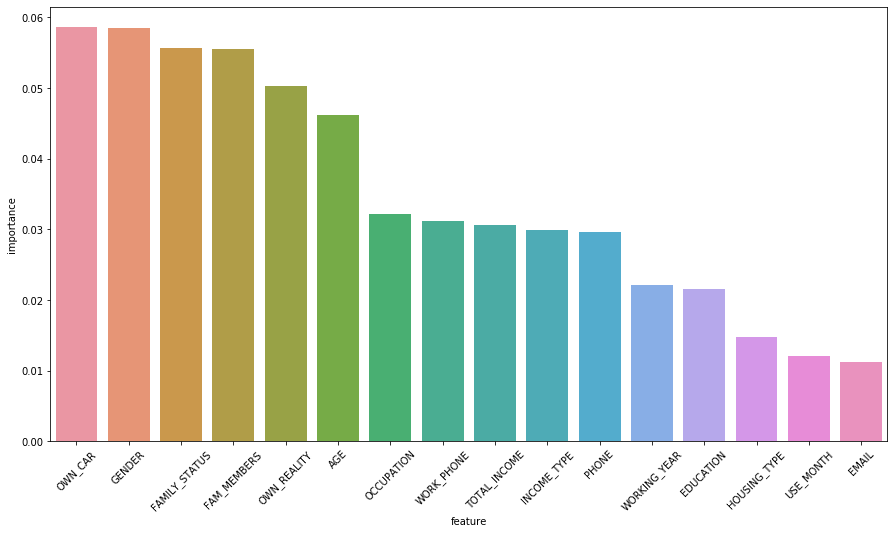

In [56]:
importances = pd.DataFrame({'feature' : X_test_sm.columns,
                            'importance' : permuter.feature_importances_}).sort_values('importance', ascending=False)

sns.barplot(x='feature', y='importance', data=importances)
plt.xticks(rotation=45);

의외의 결과이다.  
 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


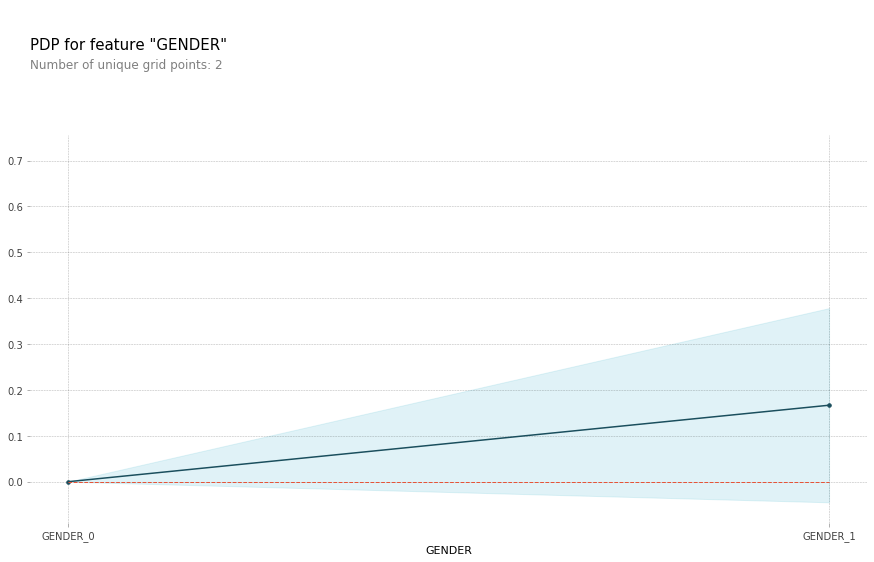

In [57]:
# GENDER
isolate_income = pdp_isolate(model = best_model_rf_fin,
                             dataset = X_test_sm,
                             model_features = X_test_sm.columns,
                             feature = 'GENDER',
                             grid_type='percentile',
                             num_grid_points=10
)

pdp_plot(isolate_income, feature_name = 'GENDER');

# 여성일수록 연체가 생길 확률이 높다

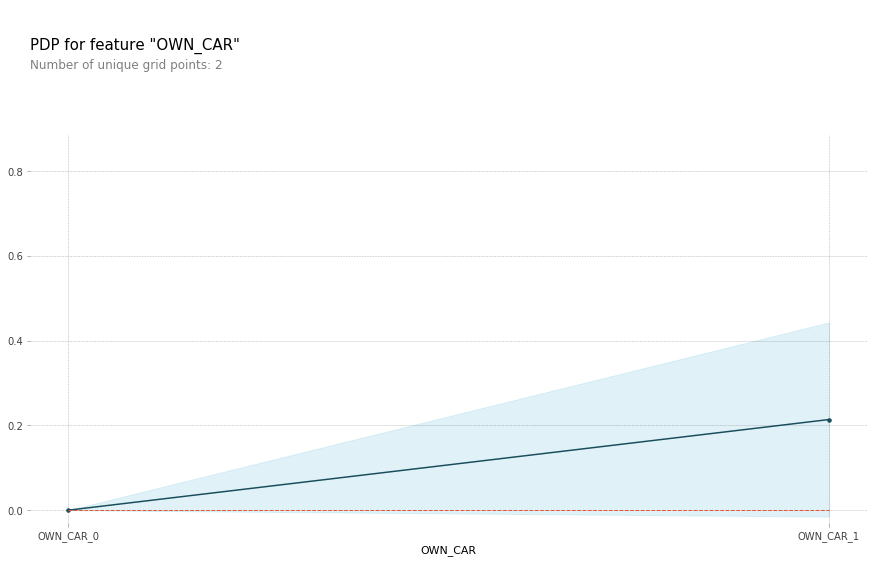

In [58]:
# OWN_CAR
isolate_income = pdp_isolate(model = best_model_rf_fin,
                             dataset = X_test_sm,
                             model_features = X_test_sm.columns,
                             feature = 'OWN_CAR',
                             grid_type='percentile',
                             num_grid_points=10
)

pdp_plot(isolate_income, feature_name = 'OWN_CAR');

# 자차를 가지고 있을 수록 연체 확률이 높다.

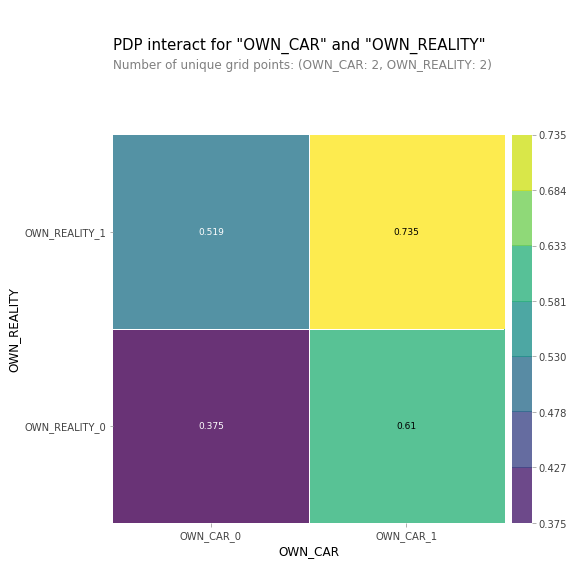

In [63]:
features = ['OWN_CAR', 'OWN_REALITY']

interaction = pdp_interact(
    model = best_model_rf_fin, 
    dataset=X_test_sm,
    model_features=X_test_sm.columns, 
    features=features)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

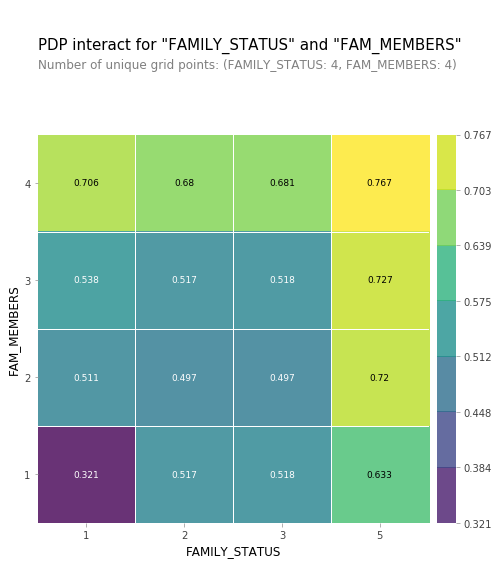

In [64]:
features = ['FAMILY_STATUS', 'FAM_MEMBERS']

interaction = pdp_interact(
    model = best_model_rf_fin, 
    dataset=X_test_sm,
    model_features=X_test_sm.columns, 
    features=features)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

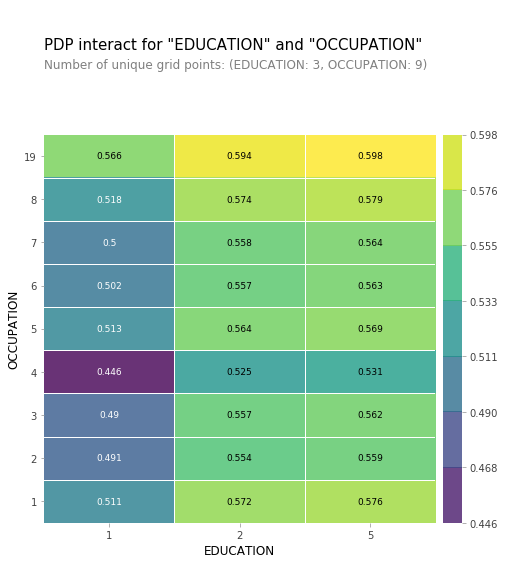

In [70]:
features = ['EDUCATION', 'OCCUPATION']

interaction = pdp_interact(
    model = best_model_rf_fin, 
    dataset=X_test_sm,
    model_features=X_test_sm.columns, 
    features=features)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

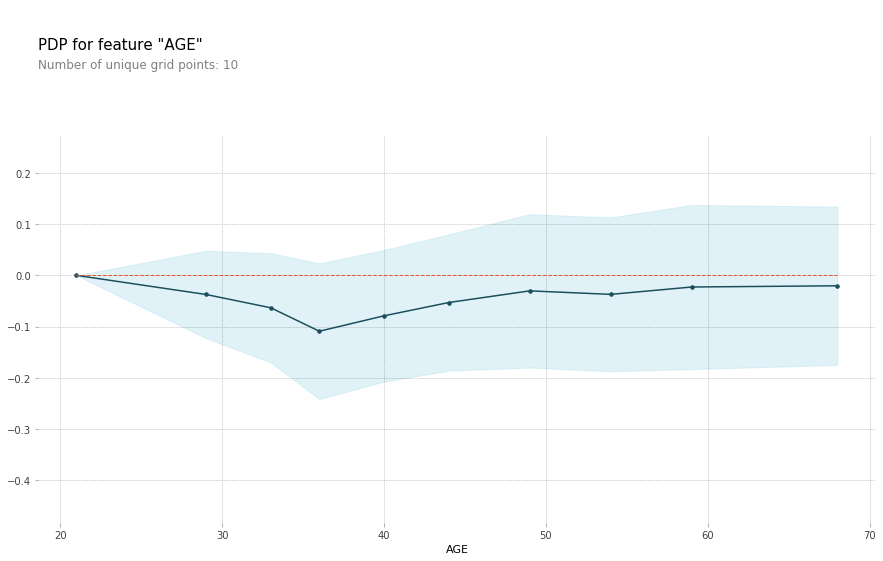

In [59]:
# TOTAL_INCOME
isolate_income = pdp_isolate(model = best_model_rf_fin,
                             dataset = X_test_sm,
                             model_features = X_test_sm.columns,
                             feature = 'AGE',
                             grid_type='percentile',
                             num_grid_points=10
)

pdp_plot(isolate_income, feature_name = 'AGE');
# 나이가 어릴수록 상대적으로 연체에 영향을 줄 확률이 많은 것으로 나타났다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


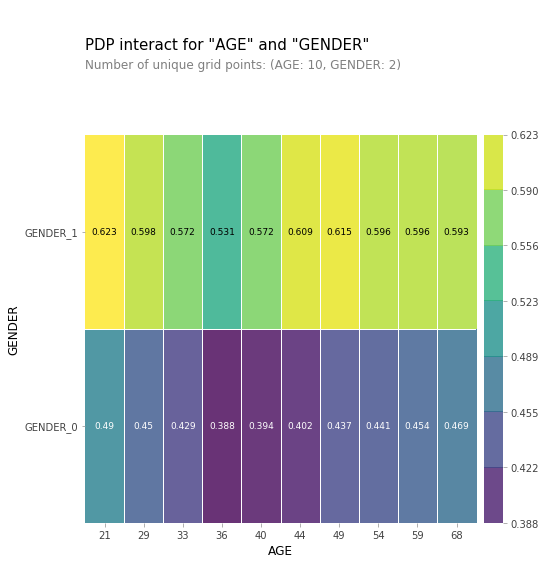

In [60]:
features = ['AGE', 'GENDER']

interaction = pdp_interact(
    model = best_model_rf_fin, 
    dataset=X_test_sm,
    model_features=X_test_sm.columns, 
    features=features)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

# 결과 해석

가설로 설정했던 '나이'는 연체 여부에 연관성이 있음을 알 수 있었다.  
특히 20대 여성일수록 크게 나타났으며, 40대 여성에게서도 높은 확률로 연체가 발생함을 확인 할 수 있다.  